## PFT

### Training the model on FIA dataset

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Libraries for modeling
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report 
from xgboost import XGBClassifier
import time
from shapely.geometry import Point
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer

In [1230]:
# Reading the data file - FIATreeSpeciesCode_pft.csv
df_fia_species = pd.read_csv("./data/FIATreeSpeciesCode_pft.csv", sep=";")
df_fia_species_imp = df_fia_species[['SPCD', 'COMMON_NAME', 'PFT']].copy()

# Reading the data file - CA_TREE.csv
df_fia_tree = pd.read_csv("./data/CA_TREE.csv", low_memory=False)
df_fia_tree_imp = df_fia_tree[['STATECD', 'PLOT', 'PLT_CN', 'UNITCD', 'COUNTYCD', 'TREE', 'SPCD', 'DIA', 'HT', 'CR']].copy()

# Reading the data file - CA_PLOT.csv
df_fia_plot = pd.read_csv("./data/CA_PLOT.csv", low_memory=False)
df_fia_plot_imp = df_fia_plot[['PLOT_STATUS_CD', 'LAT', 'LON', 'ELEV', 'ECOSUBCD', 'CN']].copy()

# Analyzing the shape
print(df_fia_species_imp.shape)
print(df_fia_tree_imp.shape)
print(df_fia_plot_imp.shape)

(458, 3)
(427519, 10)
(42036, 6)


In [1231]:
# Merging the FIA Species and FIA tree based on SPCD
df_fia = df_fia_tree_imp.merge(df_fia_species_imp, on="SPCD", how="left")
# Merging the resulting FIA dataset and FIA plot based on PLOT_CN and CN
df_fia = df_fia.merge(df_fia_plot_imp, left_on="PLT_CN", right_on="CN", how="left")
print(df_fia.shape)
df_fia.head()

(427519, 18)


,STATECD,PLOT,PLT_CN,UNITCD,COUNTYCD,TREE,SPCD,DIA,HT,CR,COMMON_NAME,PFT,PLOT_STATUS_CD,LAT,LON,ELEV,ECOSUBCD,CN
0,6,1,11839,1,15,675267,631.0,3.9,43.0,15.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
1,6,1,11839,1,15,675268,202.0,24.1,95.0,45.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839
2,6,1,11839,1,15,675269,631.0,14.2,56.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
3,6,1,11839,1,15,675270,631.0,10.5,52.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
4,6,1,11839,1,15,675271,202.0,2.5,41.0,25.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839


In [1232]:
# Convert inches to cm
df_fia['DIA'] = df_fia['DIA'] * 2.54 
# Calculating the basal area
df_fia['BasalA'] = (np.pi * df_fia['DIA']**2) / (4 * 144)
df_fia.head()

,STATECD,PLOT,PLT_CN,UNITCD,COUNTYCD,TREE,SPCD,DIA,HT,CR,COMMON_NAME,PFT,PLOT_STATUS_CD,LAT,LON,ELEV,ECOSUBCD,CN,BasalA
0,6,1,11839,1,15,675267,631.0,9.906,43.0,15.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839,0.535210
1,6,1,11839,1,15,675268,202.0,61.214,95.0,45.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839,20.437554
2,6,1,11839,1,15,675269,631.0,36.068,56.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839,7.095312
3,6,1,11839,1,15,675270,631.0,26.670,52.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839,3.879479
4,6,1,11839,1,15,675271,202.0,6.350,41.0,25.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839,0.219925


In [1233]:
# Analyzing the distribution of PFT
df_fia['PFT'].value_counts()

PFT
Evergreen conifer          279767
Evergreen broadleaf         57704
Deciduous broadleaf         49594
Deciduous                   33760
Evergreen                    6431
Flowering plants              230
Unknown                         6
Broadleaf                       4
Nitrogen fixing legumes         2
Deciduous confier               2
Name: count, dtype: int64

As we can observe the data is particularly skewed towards Evergreen conifer. However, we wanted to develop a general model particularly focusing on the sites

    "Shaver Lake (SHA)": "M261Ep",

    "Sedgwick Reserve (SDR)": "261Ba",

    "Calaveras Big Trees State Park": "M261Em",

    "Pacific Union College (PUC)": "263Am",

    "Independence Lake (IND)": "M261Ej",

    "Winton-Schaads VMP (WIN)" :"M261Em",

So we need to filter these sites based on ECOSUBCD, but first let's select the important features

In [1234]:
# Selecting the important features
df_fia_important_features = df_fia[['DIA', 'HT', 'BasalA', 'LAT', 'LON', 'COMMON_NAME', 'SPCD', 'ECOSUBCD', 'PFT']].copy()
df_fia_important_features.head()

,DIA,HT,BasalA,LAT,LON,COMMON_NAME,SPCD,ECOSUBCD,PFT
0,9.906,43.0,0.535210,41.478172,-123.946777,tanoak,631.0,263Ab,Deciduous
1,61.214,95.0,20.437554,41.478172,-123.946777,Douglas-fir,202.0,263Ab,Evergreen conifer
2,36.068,56.0,7.095312,41.478172,-123.946777,tanoak,631.0,263Ab,Deciduous
3,26.670,52.0,3.879479,41.478172,-123.946777,tanoak,631.0,263Ab,Deciduous
4,6.350,41.0,0.219925,41.478172,-123.946777,Douglas-fir,202.0,263Ab,Evergreen conifer


In [1235]:
# Dropping rows with missing values
print("Shape before:", df_fia_important_features.shape)
df_fia_important_features = df_fia_important_features.dropna(axis=0).copy()
print("Shape before:", df_fia_important_features.shape)
df_fia_important_features.head()

Shape before: (427519, 9)
Shape before: (389048, 9)


,DIA,HT,BasalA,LAT,LON,COMMON_NAME,SPCD,ECOSUBCD,PFT
0,9.906,43.0,0.535210,41.478172,-123.946777,tanoak,631.0,263Ab,Deciduous
1,61.214,95.0,20.437554,41.478172,-123.946777,Douglas-fir,202.0,263Ab,Evergreen conifer
2,36.068,56.0,7.095312,41.478172,-123.946777,tanoak,631.0,263Ab,Deciduous
3,26.670,52.0,3.879479,41.478172,-123.946777,tanoak,631.0,263Ab,Deciduous
4,6.350,41.0,0.219925,41.478172,-123.946777,Douglas-fir,202.0,263Ab,Evergreen conifer


In [1236]:
# Shortlisting the data based on the sites to focus on

# Define the ECOSUBCDs to keep
ecosubcd_keep = ['M261Ep', '261Ba', 'M261Em', '263Am', 'M261Ej']

# Filter the DataFrame
df_fia_filtered = df_fia_important_features[df_fia_important_features['ECOSUBCD'].isin(ecosubcd_keep)]
# Shuffle the filtered DataFrame
df_fia_filtered_shuffled = df_fia_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

# Keeping the original ECOSUBCD column for later use
df_fia_ecosubcd = df_fia_filtered_shuffled['ECOSUBCD']

# One hot encoding the categorical variable ECOSUBCD
df_fia_encoded = pd.get_dummies(df_fia_filtered_shuffled, columns=['ECOSUBCD'])
df_fia_encoded = df_fia_encoded.drop(['ECOSUBCD_M261Ep'], axis=1)
df_fia_encoded['ECOSUBCD'] = df_fia_ecosubcd
df_fia_encoded.head()

,DIA,HT,BasalA,LAT,LON,COMMON_NAME,SPCD,PFT,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD
0,15.494,25.0,1.309346,37.514660,-119.737508,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep
1,2.540,7.0,0.035188,38.153364,-120.059054,white fir,15.0,Evergreen conifer,False,False,False,True,M261Em
2,42.672,66.0,9.931467,37.075657,-119.382396,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep
3,43.688,49.0,10.410024,38.605369,-120.371609,incense-cedar,81.0,Evergreen conifer,False,False,False,True,M261Em
4,19.812,40.0,2.140839,37.370380,-119.540933,sugar pine,117.0,Evergreen conifer,False,False,False,False,M261Ep


In [1237]:
# Making the corrections to the PFT column based on the email
replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
df_fia_encoded['PFT'] = df_fia_encoded['PFT'].replace(replace_dict)
df_encoded = df_fia_encoded[df_fia_encoded['PFT'] != 'Broadleaf']
df_encoded['PFT'].value_counts()

PFT
Evergreen conifer      16936
Evergreen broadleaf     3476
Deciduous broadleaf     2872
Evergreen                425
Flowering plants          15
Name: count, dtype: int64

In [1238]:
# Analyzing the distribution of PFT across different ECOSUBCDs
df_encoded.groupby('ECOSUBCD')['PFT'].value_counts(normalize=True) * 100

ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    98.969072
          Deciduous broadleaf     1.030928
263Am     Evergreen broadleaf    34.610778
          Evergreen conifer      24.431138
          Deciduous broadleaf    20.958084
          Evergreen              20.000000
M261Ej    Evergreen conifer      96.108742
          Deciduous broadleaf     3.837953
          Flowering plants        0.053305
M261Em    Evergreen conifer      82.695741
          Evergreen broadleaf     8.926294
          Deciduous broadleaf     8.365213
          Flowering plants        0.012752
M261Ep    Evergreen conifer      62.702124
          Evergreen broadleaf    19.540230
          Deciduous broadleaf    16.754335
          Evergreen               0.886421
          Flowering plants        0.116891
Name: proportion, dtype: float64

A lot of sites are skewed towards a particular PFT type, so location plays an important role in this distribution. When we consider this to our intuition, it makes sense as certain types of trees are located in the certain areas.

We will now transform the data for training and train the model

In [1239]:
df_clean = df_encoded.copy()

# Defining the independent and dependent variables
independent_variables = ['DIA', 'HT', 'BasalA', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']
dependent_variable = "PFT"
include_variables = independent_variables + [dependent_variable]

# Separate features (X) and target (y)
X = df_clean[independent_variables]
y = df_clean[dependent_variable]

# Printing the class distribution
print("Class distribution in the dataset:")
print(y.value_counts(normalize=True))

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print(f"Encoded classes: {list(le.classes_)}")
print(f"Number of classes: {num_classes}")

# Split into training and test sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

print(f"Original Training set size: {len(X_train)}")
print(f"Original Test set size: {len(X_test)}")

# Feature Scaling
numerical_cols = ['DIA','HT', 'BasalA', 'LAT', 'LON']
categorical_cols = [col for col in independent_variables if col not in numerical_cols]

scaler = StandardScaler()

# Scale numerical features
X_train_scaled_num = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled_num = scaler.transform(X_test[numerical_cols])

X_train_processed = np.hstack((X_train_scaled_num, X_train[categorical_cols].values))
X_test_processed = np.hstack((X_test_scaled_num, X_test[categorical_cols].values))

# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed, y_train_encoded, test_size=0.30, random_state=42, stratify=y_train_encoded
)
start_time = time.time()

# --- Best Base Models ---

rf = RandomForestClassifier(
    n_estimators=317,
    max_depth=23,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    criterion='log_loss',
    class_weight='balanced',
    random_state=42
)

et = ExtraTreesClassifier(
    n_estimators=317,
    max_depth=23,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    criterion='log_loss',
    random_state=42
)

dt = DecisionTreeClassifier(
    max_depth=14,
    min_samples_split=13,
    min_samples_leaf=3,
    max_features=None,
    criterion='gini',
    splitter='best',
    random_state=42
)

bagging = BaggingClassifier(
    n_estimators=71,
    max_samples=0.616,
    max_features=0.987,
    bootstrap=False,
    bootstrap_features=False,
    random_state=42
)

# --- Meta-Learner ---
meta_learner = XGBClassifier(
    n_estimators=180,
    max_depth=13,
    learning_rate=0.0116,
    subsample=0.803,
    colsample_bytree=0.886,
    gamma=0.994,
    reg_alpha=0.711,
    reg_lambda=0.790,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# --- Stacking Ensemble ---
final_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('et', et),
        ('dt', dt),
        ('bagging', bagging)
    ],
    final_estimator=meta_learner,
    cv=skf,
    n_jobs=-1,
    passthrough=True
)

final_model.fit(
    X_train_final,
    y_train_final,
)

print(f"Final model training finished. Time: {time.time() - start_time:.2f} seconds")
print("-" * 30)

# --- Predict and Evaluate on the Test Set ---
print("Evaluating model on the test set...")

# Predict using the final model
predicted_pft_test_encoded = final_model.predict(X_test_processed)

# Decode predictions for readability
predicted_labels_decoded = le.inverse_transform(predicted_pft_test_encoded)

# Get original test labels for comparison
original_test_labels = le.inverse_transform(y_test_encoded)

# Classification report
report = classification_report(
    original_test_labels,
    predicted_labels_decoded,
    zero_division=0,
    target_names=le.classes_
)
print("Classification Report on Test Set:")
print(report)

Class distribution in the dataset:
PFT
Evergreen conifer      0.713876
Evergreen broadleaf    0.146518
Deciduous broadleaf    0.121059
Evergreen              0.017914
Flowering plants       0.000632
Name: proportion, dtype: float64
Encoded classes: ['Deciduous broadleaf', 'Evergreen', 'Evergreen broadleaf', 'Evergreen conifer', 'Flowering plants']
Number of classes: 5
Original Training set size: 17793
Original Test set size: 5931


/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:09:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final model training finished. Time: 31.27 seconds
------------------------------
Evaluating model on the test set...
Classification Report on Test Set:
                     precision    recall  f1-score   support

Deciduous broadleaf       0.75      0.64      0.69       718
          Evergreen       0.69      0.75      0.71       106
Evergreen broadleaf       0.85      0.81      0.83       869
  Evergreen conifer       0.93      0.96      0.95      4234
   Flowering plants       1.00      0.50      0.67         4

           accuracy                           0.90      5931
          macro avg       0.84      0.73      0.77      5931
       weighted avg       0.89      0.90      0.89      5931



A lot of sites are skewed towards a particular PFT, so location might play an important role in this distribution. When we consider this to our intuition, it makes sense as certain types of trees are located in the certain areas.

### Working with TLS Data for prediction

In [1240]:
# Loading the TLS data
tls_treelist_df = pd.read_csv("./data/TLS_treelist.csv", index_col=0)
df_tls_plot_identification = pd.read_csv("./data/blk_plot_identification.csv")
df_tls_data = tls_treelist_df.merge(df_tls_plot_identification,on="plot_blk", how="left")
df_tls_data.head()

,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,...,plot_num,inventory_date,inventory_hour,plot_coord_x,plot_coord_y,plot_coord_srs,plot_declination,inventory_plot_diam,plot_slopeper,plot_aspectdegre
0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,20.987379,2.402324,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
1,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,13.105771,0.936786,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
2,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,59.840890,19.530404,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
3,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,21.040854,2.414582,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
4,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,16.390056,1.465130,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0


In [1241]:
# Checking the distribution of the site names
df_tls_data['site_name_label'].value_counts()

site_name_label
Calaveras Big Trees State Park    408
Independence Lake (IND)           229
Shaver Lake (SHA)                 209
Winton-Schaads VMP (WIN)          176
Pacific Union College (PUC)       176
Sedgwick Reserve (SDR)             88
Name: count, dtype: int64

In [1242]:
print("Shape before:",df_tls_data.shape)
# Dropping the null values
df_tls_data = df_tls_data.dropna(axis=0).copy()
print("Shape after:",df_tls_data.shape)

Shape before: (1382, 28)
Shape after: (1286, 28)


In [ ]:
# Converting X, Y coordinates to Latitude and Longitude
gdfs = []
for crs in df_tls_data["plot_coord_srs"].unique():
    df_crs = df_tls_data[df_tls_data["plot_coord_srs"] == crs]
    geometry = [Point(xy) for xy in zip(df_crs["X"], df_crs["Y"])]
    gdf = gpd.GeoDataFrame(df_crs, geometry=geometry, crs=f"EPSG:{crs}")
    gdf = gdf.to_crs(epsg=4326)
    gdfs.append(gdf)

# Recombine the GeoDataFrames
gdf = pd.concat(gdfs)
gdf["longitude"] = gdf.geometry.x
gdf["latitude"] = gdf.geometry.y

df_tls_data['LAT'] = gdf['latitude']
df_tls_data['LON'] = gdf['longitude']

In [1244]:
# Now we will map the site names to the corresponding ECOSUBCDs
#  Define mapping
site_to_ecosubcd = {
    "Shaver Lake (SHA)": "M261Ep",
    "Sedgwick Reserve (SDR)": "261Ba",
    "Calaveras Big Trees State Park": "M261Em",
    "Pacific Union College (PUC)": "263Am",
    "Independence Lake (IND)": "M261Ej",
    "Winton-Schaads VMP (WIN)" :"M261Em",
}

# Create Ecosubcd column based on site names
df_tls_data['ECOSUBCD'] = df_tls_data['site_name_label'].map(site_to_ecosubcd)

In [1245]:
# Selecting important features from the TLS data
TLS_X = df_tls_data[['DBH', 'H', 'BasalA', 'LAT', 'LON', 'ECOSUBCD']].copy()
# Renaming columns for consistency
TLS_X.columns = ['DIA', 'HT', 'BasalA', 'LAT', 'LON', 'ECOSUBCD']

In [1246]:
# One hot encoding the categorical variable ECOSUBCD
TLS_X_ECOSUBCD = TLS_X['ECOSUBCD'].copy()
TLS_X = pd.get_dummies(TLS_X, columns=['ECOSUBCD'])
# Dropping one of the dummy variables to avoid the dummy variable trap
TLS_X = TLS_X.drop(['ECOSUBCD_M261Ep'], axis=1)
TLS_X = TLS_X[['DIA', 'HT', 'BasalA', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']]
TLS_X['ECOSUBCD'] = TLS_X_ECOSUBCD

# Shuffle the filtered DataFrame
TLS_X_shuffled = TLS_X.sample(frac=1, random_state=42).reset_index(drop=True)
TLS_X_shuffled = TLS_X.copy()

# dropping the null values
TLS_X_shuffled = TLS_X_shuffled.dropna(axis=0).copy()
TLS_X_shuffled.head()

,DIA,HT,BasalA,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD
0,20.987379,12.560,2.402324,0.000019,-121.488648,False,False,False,False,M261Ep
1,13.105771,8.742,0.936786,0.000010,-121.488722,False,False,False,False,M261Ep
2,59.840890,13.469,19.530404,0.000009,-121.488725,False,False,False,False,M261Ep
3,21.040854,18.144,2.414582,0.000079,-121.488726,False,False,False,False,M261Ep
4,16.390056,13.790,1.465130,0.000002,-121.488731,False,False,False,False,M261Ep


In [1247]:
# Defining the independent variables

independent_variables = ['DIA','HT', 'BasalA', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']

numerical_cols = ['DIA', 'HT', 'BasalA', 'LAT', 'LON']
categorical_cols = [col for col in independent_variables if col not in numerical_cols]

In [1248]:
# Scale numerical features
TLS_X_scaled = scaler.fit_transform(TLS_X_shuffled[numerical_cols])
TLS_train_processed = np.hstack((TLS_X_scaled, TLS_X_shuffled[categorical_cols].values))

# Predicting the PFTs using the final model
predicted_pft_tls = final_model.predict(TLS_train_processed)
# Decode predictions for readability
predicted_labels_TLS_decoded = le.inverse_transform(predicted_pft_tls)
print("Length of predicted PFTs:",len(predicted_labels_TLS_decoded))

# Adding the predicted PFTs to the TLS data
TLS_X['predicted_PFT'] = predicted_labels_TLS_decoded
print(TLS_X['predicted_PFT'].value_counts())
print("-" * 30)

# Calculate value counts as percentages
percentages = TLS_X['predicted_PFT'].value_counts(normalize=True) * 100

print("-" * 30)
print("Percentage distribution of predicted PFTs:")
# Round and display
percentages = percentages.round(2)
print(percentages)

Length of predicted PFTs: 1286
predicted_PFT
Evergreen conifer      1006
Evergreen broadleaf     253
Deciduous broadleaf      27
Name: count, dtype: int64
------------------------------
------------------------------
Percentage distribution of predicted PFTs:
predicted_PFT
Evergreen conifer      78.23
Evergreen broadleaf    19.67
Deciduous broadleaf     2.10
Name: proportion, dtype: float64


In [1249]:
# Calculate value counts as percentages
percentages = TLS_X.groupby('ECOSUBCD')['predicted_PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  predicted_PFT      
261Ba     Evergreen broadleaf    87.50
          Evergreen conifer      12.50
263Am     Evergreen conifer      61.93
          Evergreen broadleaf    35.80
          Deciduous broadleaf     2.27
M261Ej    Evergreen conifer      96.07
          Evergreen broadleaf     3.93
M261Em    Evergreen conifer      87.67
          Evergreen broadleaf     8.56
          Deciduous broadleaf     3.77
M261Ep    Evergreen conifer      73.68
          Evergreen broadleaf    25.84
          Deciduous broadleaf     0.48
Name: proportion, dtype: float64


### Working with Field_data

Now we will load the Field data to compare our predictions

In [1250]:
df_field = pd.read_csv("./data/03_tree.csv")
df_field_plot = pd.read_csv("./data/01_plot_identification.csv")

print(df_field.shape)
print(df_field_plot.shape)

(2147, 22)
(163, 61)


In [1251]:
# Identifying the scientific names in the field data that are not mapped with the FIA data
field_names = set(df_field['tree_sp_scientific_name'].value_counts().index)
fia_names = set(df_fia_species['SCI_NAME'].value_counts().index)
difference = list(field_names - fia_names)
difference

['Quercus sp.', 'Salix sp.', 'Notholicarpos densiflorus', 'Cornus nuttalii']

In [1252]:
# Creating a mapping for the differences to maintain uniformity
replace_dict = {'Salix spp.': 'Salix sp.', 'Quercus spp.': 'Quercus sp.', 'Cornus nuttallii': 'Cornus nuttalii'} 
df_fia_species['SCI_NAME'] = df_fia_species['SCI_NAME'].replace(replace_dict)

In [1253]:
# Merging the field data with the plot data and then with the FIA species data
df_field = df_field.merge(df_field_plot, on="inventory_id", how="left")
df_field = df_field.merge(df_fia_species, left_on="tree_sp_scientific_name", right_on="SCI_NAME", how="left")
print("Field data shape:",df_field.shape)
df_field.head()

Field data shape: (2147, 94)


,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,SCI_NAME,SPGRPCD.E,SPGRPCD.W,MAJGRP,OCC.NC,OCC.NE,OCC.PNW,OCC.RM,OCC.SO,PFT
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,Abies concolor,9.0,12.0,2.0,X,-,X,X,X,Evergreen conifer
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,Abies concolor,9.0,12.0,2.0,X,-,X,X,X,Evergreen conifer
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,Abies concolor,9.0,12.0,2.0,X,-,X,X,X,Evergreen conifer
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,Abies concolor,9.0,12.0,2.0,X,-,X,X,X,Evergreen conifer
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,Abies concolor,9.0,12.0,2.0,X,-,X,X,X,Evergreen conifer


In [1254]:
# Replacing Deciduous with Deciduous broadleaf as both are the same
replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
df_field['PFT'] = df_field['PFT'].replace(replace_dict)

In [1255]:
# Calculate value counts as percentages
percentages = df_field['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print("Field data PFT distribution:")
print(percentages)
print("-" * 30)

print("Predicted TLS data distribution:")
percentages = TLS_X['predicted_PFT'].value_counts(normalize=True) * 100
percentages = percentages.round(2)
print(percentages)

Field data PFT distribution:
PFT
Evergreen conifer      71.96
Evergreen broadleaf    19.01
Deciduous broadleaf     8.98
Tree                    0.05
Name: proportion, dtype: float64
------------------------------
Predicted TLS data distribution:
predicted_PFT
Evergreen conifer      78.23
Evergreen broadleaf    19.67
Deciduous broadleaf     2.10
Name: proportion, dtype: float64


Here, we can see that the overall distribution from our model is pretty close to the actual distribution of the site data, with Evergreen broadleaf distribution being almost the same

In [1256]:
# Define your mapping
site_to_ecosubcd = {
    "Shaver Lake (SHA)": "M261Ep",
    "Sedgwick Reserve (SDR)": "261Ba",
    "Calaveras Big Trees State Park": "M261Em",
    "Pacific Union College (PUC)": "263Am",
    "Independence Lake (IND)": "M261Ej",
    "Winton-Schaads VMP (WIN)" :"M261Em",
}

# Create new column
df_field['ECOSUBCD'] = df_field['site_name_label'].map(site_to_ecosubcd)
# Calculate value counts as percentages
percentages = df_field.groupby('ECOSUBCD')['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    84.07
          Deciduous broadleaf    15.93
263Am     Evergreen conifer      53.77
          Evergreen broadleaf    35.18
          Deciduous broadleaf    11.06
M261Ej    Evergreen conifer      93.58
          Deciduous broadleaf     6.42
M261Em    Evergreen conifer      89.31
          Deciduous broadleaf     8.11
          Evergreen broadleaf     2.46
          Tree                    0.12
M261Ep    Evergreen conifer      94.83
          Deciduous broadleaf     5.17
Name: proportion, dtype: float64


In [1257]:
# Calculate value counts as percentages
percentages = TLS_X.groupby('ECOSUBCD')['predicted_PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  predicted_PFT      
261Ba     Evergreen broadleaf    87.50
          Evergreen conifer      12.50
263Am     Evergreen conifer      61.93
          Evergreen broadleaf    35.80
          Deciduous broadleaf     2.27
M261Ej    Evergreen conifer      96.07
          Evergreen broadleaf     3.93
M261Em    Evergreen conifer      87.67
          Evergreen broadleaf     8.56
          Deciduous broadleaf     3.77
M261Ep    Evergreen conifer      73.68
          Evergreen broadleaf    25.84
          Deciduous broadleaf     0.48
Name: proportion, dtype: float64


Here we can see that even the site wise distributions are pretty close as well

## GENUS

In [1258]:
# Creating a copy of the above dataframe for the FIA genus
df_fia_genus = df_encoded.copy()
df_fia_genus.head()

,DIA,HT,BasalA,LAT,LON,COMMON_NAME,SPCD,PFT,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD
0,15.494,25.0,1.309346,37.514660,-119.737508,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep
1,2.540,7.0,0.035188,38.153364,-120.059054,white fir,15.0,Evergreen conifer,False,False,False,True,M261Em
2,42.672,66.0,9.931467,37.075657,-119.382396,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep
3,43.688,49.0,10.410024,38.605369,-120.371609,incense-cedar,81.0,Evergreen conifer,False,False,False,True,M261Em
4,19.812,40.0,2.140839,37.370380,-119.540933,sugar pine,117.0,Evergreen conifer,False,False,False,False,M261Ep


In [1259]:
# Loading the reference species data to get info on GENUS and SPECIES
df_ref_species = pd.read_csv('./data/REF_SPECIES.csv')
df_ref_species = df_ref_species[['SPCD', 'GENUS', 'SPECIES', 'COMMON_NAME']].copy()
print(f"Shape: {df_ref_species.shape}")
df_ref_species.head()

Shape: (2677, 4)


,SPCD,GENUS,SPECIES,COMMON_NAME
0,6156.0,Araucaria,excelsa,Norfolk Island pine
1,6157.0,Araucaria,heterophylla,Norfolk Island pine
2,6158.0,Araucaria,spp.,Araucaria
3,6159.0,Archontophoenix,alexandrae,Alexandra palm
4,6160.0,Archontophoenix,cunninghamiana,Bangalow palm


In [1260]:
# Merging the FIA data with the reference species data
df_fia_genus = df_fia_genus.merge(df_ref_species, on="SPCD", how="left")
print(f"Shape: {df_fia_genus.shape}")
df_fia_genus.head()

Shape: (23724, 16)


,DIA,HT,BasalA,LAT,LON,COMMON_NAME_x,SPCD,PFT,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,GENUS,SPECIES,COMMON_NAME_y
0,15.494,25.0,1.309346,37.514660,-119.737508,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
1,2.540,7.0,0.035188,38.153364,-120.059054,white fir,15.0,Evergreen conifer,False,False,False,True,M261Em,Abies,concolor,white fir
2,42.672,66.0,9.931467,37.075657,-119.382396,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
3,43.688,49.0,10.410024,38.605369,-120.371609,incense-cedar,81.0,Evergreen conifer,False,False,False,True,M261Em,Calocedrus,decurrens,incense-cedar
4,19.812,40.0,2.140839,37.370380,-119.540933,sugar pine,117.0,Evergreen conifer,False,False,False,False,M261Ep,Pinus,lambertiana,sugar pine


In [1261]:
# List of GENUS to keep
genus_to_keep = ['Abies', 'Calocedrus', 'Pinus', 'Cornus', 'Populus',
                  'Quercus', 'Sequoiadendron', 'Acer', 'Pseudotsuga', 'Arbutus','Salix'
                  'Notholicarpos']

# Filter the DataFrame
df_fia_genus = df_fia_genus[df_fia_genus["GENUS"].isin(genus_to_keep)].copy()
df_fia_genus.shape

(22748, 16)

In [1262]:
# # Define a function to remove outliers based on IQR
def remove_outliers_by_genus(df, column, group_by):
    Q1 = df.groupby(group_by)[column].transform('quantile', 0.25)
    Q3 = df.groupby(group_by)[column].transform('quantile', 0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [1263]:
# Check the shape
print(f"Shape before removing outliers: {df_fia_genus.shape}")

# Remove outliers based on GENUS
columns = ['DIA', 'HT', 'BasalA', 'LAT', 'LON']

for column in columns:
    df_fia_genus = remove_outliers_by_genus(df_fia_genus, column, 'GENUS')

# Check the resulting shape
print(f"Shape after removing outliers: {df_fia_genus.shape}")

Shape before removing outliers: (22748, 16)
Shape after removing outliers: (20405, 16)


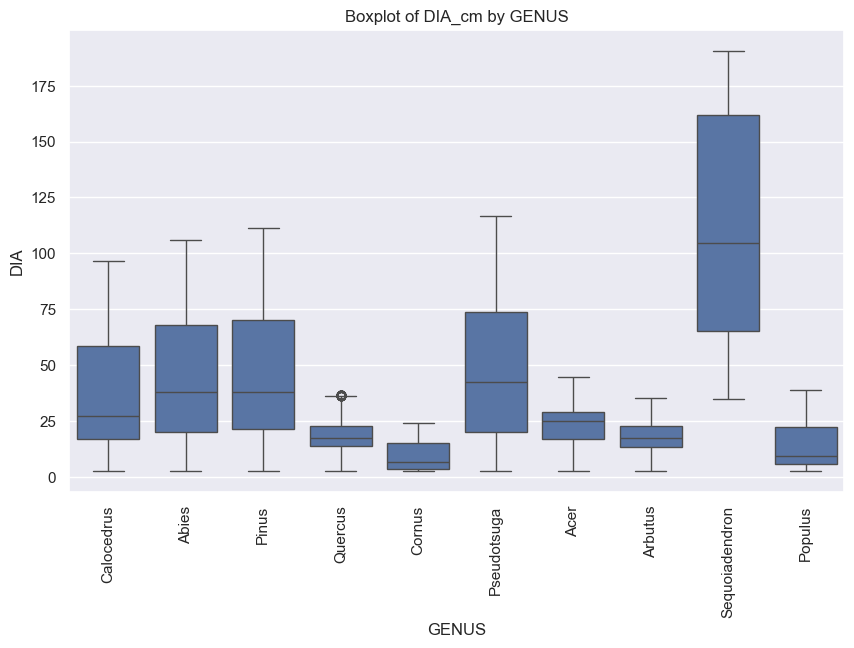

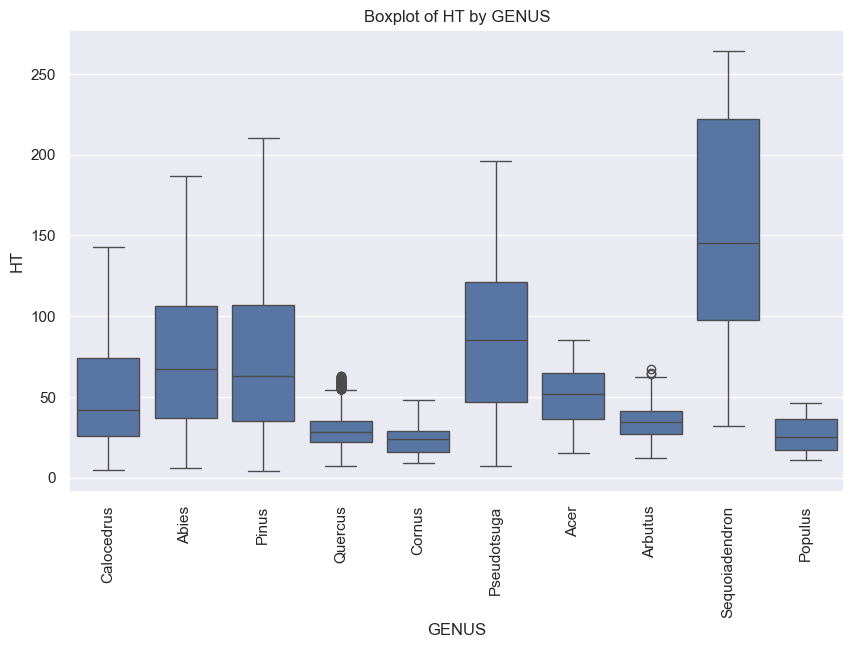

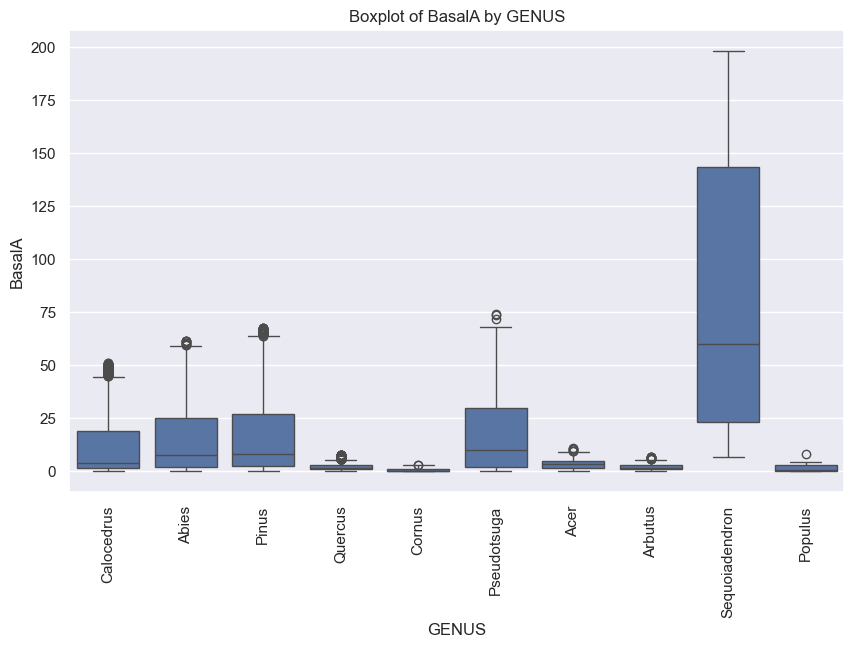

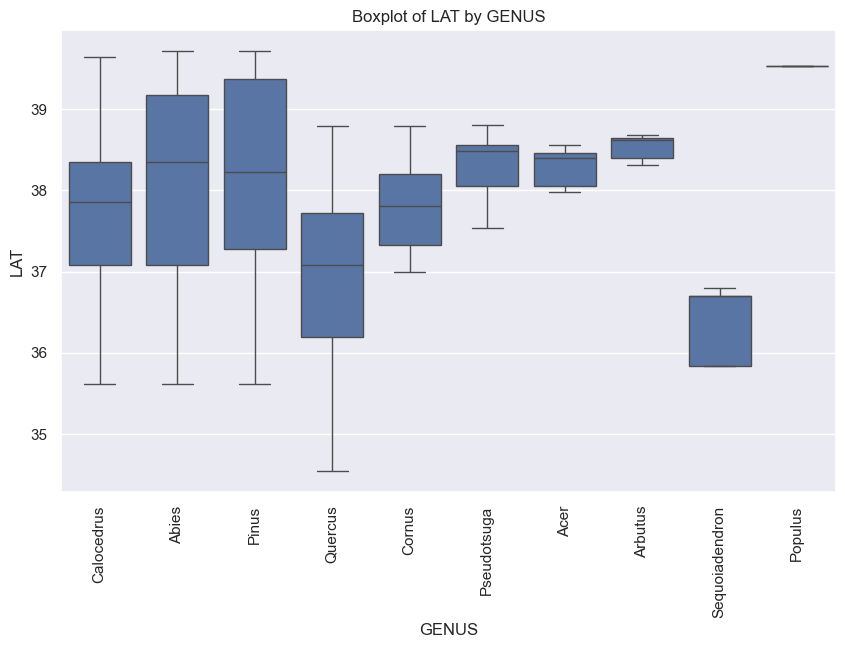

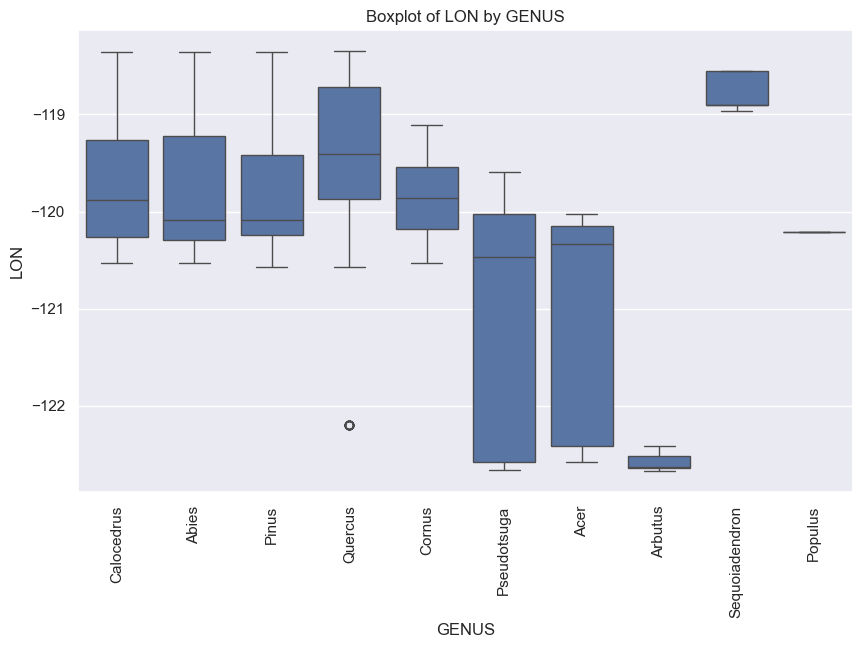

In [1264]:
# make box plots to see outliers 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='DIA', data=df_fia_genus)
plt.xticks(rotation=90)
plt.title('Boxplot of DIA_cm by GENUS')
plt.show()
plt.figure(figsize=(10, 6))

sns.boxplot(x='GENUS', y='HT', data=df_fia_genus)
plt.xticks(rotation=90)
plt.title('Boxplot of HT by GENUS')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='BasalA', data=df_fia_genus)
plt.xticks(rotation=90)
plt.title('Boxplot of BasalA by GENUS')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='LAT', data=df_fia_genus)
plt.xticks(rotation=90)
plt.title('Boxplot of LAT by GENUS')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='GENUS', y='LON', data=df_fia_genus)
plt.xticks(rotation=90)
plt.title('Boxplot of LON by GENUS')
plt.show()

In [ ]:
# Typecasting PFT as cateogorical column
df_fia_genus['PFT'] = df_fia_genus['PFT'].astype('category')

# selecting important features
include_vars = ['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT', 'GENUS']
df = df_fia_genus[include_vars].dropna().copy()

# Create the encoder
ohe = OneHotEncoder(sparse_output=False)

# Fit and transform the PFT column
pft_encoded = ohe.fit_transform(df[["PFT"]])

# Convert to DataFrame with appropriate column names
pft_encoded_df = pd.DataFrame(
    pft_encoded,
    columns=[f"PFT_{cat}" for cat in ohe.categories_[0]],
    index=df.index
)

# Drop the original PFT column and join the encoded columns
df = df.drop(columns=["PFT"])
df = pd.concat([df, pft_encoded_df], axis=1)

df.rename(columns={"DIA": "DIA"}, inplace=True)
X = df.drop(columns=["GENUS"])
y = df["GENUS"]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)


# Stratified train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.30, stratify=y_encoded , random_state=42,
)


# Identify numerical and categorical columns again
numerical_cols = ['DIA', 'HT', 'LAT', 'LON']
categorical_cols = [col for col in X.columns if col not in numerical_cols]

# Create column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
    ]
)

# Fit and transform training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


# Concatenate scaled numerical and raw categorical columns
X_train_processed = np.hstack((X_train_scaled, X_train[categorical_cols].values))
X_test_processed = np.hstack((X_test_scaled, X_test[categorical_cols].values))

In [1266]:
# Checking the distribution
print(df_fia_genus["GENUS"].value_counts())
print("Len :",len(df_fia_genus["GENUS"].unique()))

GENUS
Pinus             5714
Abies             4924
Calocedrus        4835
Quercus           3879
Pseudotsuga        621
Arbutus            200
Cornus             109
Acer                73
Sequoiadendron      30
Populus             20
Name: count, dtype: int64
Len : 10


In [1267]:
# Assume X, y_encoded are your full datasets with the same number of rows
assert len(X) == len(y_encoded), "X and y_encoded must have the same number of rows."

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_encoded)

# Check all shapes
print(f"X: {X.shape}, y: {len(y_encoded)}, sample_weights: {len(sample_weights)}")

X: (20405, 11), y: 20405, sample_weights: 20405


In [1268]:
# Using the earlier column transformer to preprocess the data
X_new = np.hstack((preprocessor.fit_transform(X), X[categorical_cols].values))

In [1269]:
# Tuning the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Best hyperparameters found earlier
best_rf_model = RandomForestClassifier(
    class_weight={
        0: 0.4252973600232086,
        1: 28.745098039215687,
        2: 10.471428571428572,
        3: 0.4328314142308828,
        4: 18.325,
        5: 0.36314094624721327,
        6: 77.15789473684211,
        7: 3.34703196347032,
        8: 0.4827132038195588,
        9: 61.083333333333336
    },
    criterion='entropy',
    max_depth=100,
    min_samples_split=5,
    n_estimators=800,
    random_state=42
)

# Evaluation function
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

# Train and evaluate the best RF model
train_and_evaluate(best_rf_model, "Best Random Forest")

Best Random Forest - Accuracy: 0.8288, Training Time: 11.89 seconds
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1477
           1       0.82      0.82      0.82        22
           2       1.00      1.00      1.00        60
           3       0.76      0.84      0.80      1451
           4       0.81      0.91      0.86        33
           5       0.82      0.76      0.79      1714
           6       1.00      1.00      1.00         6
           7       0.85      0.81      0.83       186
           8       1.00      0.99      0.99      1164
           9       0.70      0.78      0.74         9

    accuracy                           0.83      6122
   macro avg       0.85      0.87      0.86      6122
weighted avg       0.83      0.83      0.83      6122

--------------------------------------------------


In [1270]:
# Tuning the Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Best hyperparameters from tuning
best_et_model = ExtraTreesClassifier(
    n_estimators=800,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    max_depth=30,
    criterion='entropy',
    bootstrap=False,
    random_state=42
)

# Evaluation function (already defined)
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

# Train and evaluate the final Extra Trees model
train_and_evaluate(best_et_model, "Best Extra Trees")

Best Extra Trees - Accuracy: 0.8303, Training Time: 10.44 seconds
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1477
           1       0.95      0.82      0.88        22
           2       1.00      1.00      1.00        60
           3       0.77      0.83      0.80      1451
           4       0.97      0.97      0.97        33
           5       0.82      0.78      0.80      1714
           6       1.00      1.00      1.00         6
           7       0.90      0.69      0.78       186
           8       1.00      1.00      1.00      1164
           9       1.00      0.67      0.80         9

    accuracy                           0.83      6122
   macro avg       0.92      0.85      0.88      6122
weighted avg       0.83      0.83      0.83      6122

--------------------------------------------------


In [1271]:
# Tuning the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Best hyperparameters from tuning
best_dt_model = DecisionTreeClassifier(
    splitter='best',
    min_samples_split=15,
    min_samples_leaf=4,
    max_features=None,
    max_depth=50,
    criterion='entropy',
    random_state=42
)

# Evaluation function (already defined)
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

# Train and evaluate the final Decision Tree model
train_and_evaluate(best_dt_model, "Best Decision Tree")

Best Decision Tree - Accuracy: 0.7893, Training Time: 0.06 seconds
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1477
           1       0.64      0.82      0.72        22
           2       1.00      1.00      1.00        60
           3       0.73      0.76      0.74      1451
           4       0.73      0.82      0.77        33
           5       0.78      0.70      0.74      1714
           6       1.00      1.00      1.00         6
           7       0.85      0.70      0.77       186
           8       1.00      0.99      0.99      1164
           9       0.78      0.78      0.78         9

    accuracy                           0.79      6122
   macro avg       0.82      0.83      0.82      6122
weighted avg       0.79      0.79      0.79      6122

--------------------------------------------------


In [1272]:
# Tuning the meta learner - XGBoost
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# Define base models (already trained or initialized)
base_models = [
    ('rf', best_rf_model),
    ('et', best_et_model),
    ('dt', best_dt_model)
]

# Use best config from FLAML to define the meta-learner
best_xgb_meta = XGBClassifier(
    n_estimators=50,
    learning_rate=0.14,
    max_depth=3,
    min_child_weight=3,
    subsample=0.86,
    colsample_bytree=0.9,
    gamma=0.064,
    reg_alpha=0.068,
    reg_lambda=1.4,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define the final stacking classifier
final_stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=best_xgb_meta,
    cv=5,
    n_jobs=-1
)

# Fit the stacking model
final_stack_model.fit(X_train_processed, y_train_encoded)

# Evaluate
train_and_evaluate(final_stack_model, "Stacking with Best-Tuned XGBoost")


/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:10:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stacking with Best-Tuned XGBoost - Accuracy: 0.8337, Training Time: 41.36 seconds
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1477
           1       0.86      0.86      0.86        22
           2       1.00      1.00      1.00        60
           3       0.77      0.83      0.80      1451
           4       0.97      0.91      0.94        33
           5       0.82      0.77      0.80      1714
           6       1.00      1.00      1.00         6
           7       0.90      0.73      0.80       186
           8       1.00      1.00      1.00      1164
           9       1.00      0.89      0.94         9

    accuracy                           0.83      6122
   macro avg       0.91      0.88      0.89      6122
weighted avg       0.84      0.83      0.83      6122

--------------------------------------------------


In [1273]:
# Visualizing the final stacked model
final_stack_model

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={0: 0.4252973600232086,
                                                                     1: 28.745098039215687,
                                                                     2: 10.471428571428572,
                                                                     3: 0.4328314142308828,
                                                                     4: 18.325,
                                                                     5: 0.36314094624721327,
                                                                     6: 77.15789473684211,
                                                                     7: 3.34703196347032,
                                                                     8: 0.4827132038195588,
                                                                     9: 61.083333333333336},
                                                       criterion='entropy',
                                                       max_depth=100,
                                                       min_samples_split=5,
                                                       n_estimators=800,
                                                       ran...
                                                 feature_weights=None,
                                                 gamma=0.064, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.14,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=3, max_leaves=None,
                                                 min_child_weight=3,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                   n_jobs=-1)

In [1274]:
# Fitting the data to final stacked model
final_stack_model.fit(X_new,y_encoded, sample_weight=sample_weights)

/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={0: 0.4252973600232086,
                                                                     1: 28.745098039215687,
                                                                     2: 10.471428571428572,
                                                                     3: 0.4328314142308828,
                                                                     4: 18.325,
                                                                     5: 0.36314094624721327,
                                                                     6: 77.15789473684211,
                                                                     7: 3.34703196347032,
                                                                     8: 0.4827132038195588,
                                                                     9: 61.083333333333336},
                                                       criterion='entropy',
                                                       max_depth=100,
                                                       min_samples_split=5,
                                                       n_estimators=800,
                                                       ran...
                                                 feature_weights=None,
                                                 gamma=0.064, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.14,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=3, max_leaves=None,
                                                 min_child_weight=3,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                   n_jobs=-1)

### Working with TLS data

In [1275]:
# We rename the predicted_PFT column to PFT for uniformity
TLS_X_genus = TLS_X.copy()
TLS_X_genus.columns = ['DIA', 'HT', 'BasalA', 'LAT', 'LON','ECOSUBCD_261Ba','ECOSUBCD_263Am', 'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'ECOSUBCD', 'PFT']

In [1276]:
# One-hot encode the PFT column
PFT_encoded = pd.get_dummies(TLS_X_genus['PFT'], prefix='PFT')

# Concatenate the one-hot encoded columns with the original DataFrame
TLS_X_genus = pd.concat([TLS_X_genus, PFT_encoded], axis=1)

# Drop the PFT column
TLS_X_genus.drop(columns=['PFT'], inplace=True)

TLS_X_genus['PFT_Evergreen broadleaf'] = ~TLS_X_genus['PFT_Deciduous broadleaf'] & ~TLS_X_genus['PFT_Evergreen conifer']

# Display the updated DataFrame
TLS_X_genus.head()

,DIA,HT,BasalA,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer
0,20.987379,12.560,2.402324,0.000019,-121.488648,False,False,False,False,M261Ep,False,True,False
1,13.105771,8.742,0.936786,0.000010,-121.488722,False,False,False,False,M261Ep,False,True,False
2,59.840890,13.469,19.530404,0.000009,-121.488725,False,False,False,False,M261Ep,False,True,False
3,21.040854,18.144,2.414582,0.000079,-121.488726,False,False,False,False,M261Ep,False,False,True
4,16.390056,13.790,1.465130,0.000002,-121.488731,False,False,False,False,M261Ep,False,True,False


In [1277]:
# concatenate the scaled numerical features with the categorical features
TLS_X_cat_n_num_cols = np.hstack((preprocessor.fit_transform(TLS_X_genus), TLS_X_genus[categorical_cols].values))

# Predict using the final stacked model
pred =  final_stack_model.predict(TLS_X_cat_n_num_cols)
predicted_genus = le.inverse_transform(pred)

# Adding the predicted GENUS to the TLS data
TLS_X_genus['predicted_genus'] = predicted_genus.copy()

# checking the distribution
TLS_X_genus['predicted_genus'].value_counts()

predicted_genus
Pinus             344
Pseudotsuga       282
Quercus           263
Abies             248
Calocedrus        131
Acer               17
Sequoiadendron      1
Name: count, dtype: int64

### Working with field data

In [1278]:
df_field[['GENUS', 'SPECIES']] = df_field['tree_sp_scientific_name'].str.split(' ', n=1, expand=True)
df_field.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,MAJGRP,OCC.NC,OCC.NE,OCC.PNW,OCC.RM,OCC.SO,PFT,ECOSUBCD,GENUS,SPECIES
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,2.0,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,2.0,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,2.0,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,2.0,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,2.0,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor


In [1279]:
df_fia_genus['GENUS'].value_counts(normalize=True) * 100

GENUS
Pinus             28.002940
Abies             24.131340
Calocedrus        23.695173
Quercus           19.010047
Pseudotsuga        3.043372
Arbutus            0.980152
Cornus             0.534183
Acer               0.357755
Sequoiadendron     0.147023
Populus            0.098015
Name: proportion, dtype: float64

In [1280]:
# find percentage of each predicted genus
predicted_genus_counts = TLS_X_genus['predicted_genus'].value_counts(normalize=True) * 100
# Display the percentage of each predicted genus
print("Percentage of each predicted genus:")
print(predicted_genus_counts)

Percentage of each predicted genus:
predicted_genus
Pinus             26.749611
Pseudotsuga       21.928460
Quercus           20.451011
Abies             19.284603
Calocedrus        10.186625
Acer               1.321928
Sequoiadendron     0.077760
Name: proportion, dtype: float64


In [1281]:
df_field['GENUS'].value_counts(normalize=True) * 100

GENUS
Abies             23.800652
Calocedrus        22.263624
Quercus           21.471821
Pinus             18.258034
Pseudotsuga        5.263158
Arbutus            3.213787
Notholicarpos      2.980904
Populus            1.071262
Salix              0.791803
Cornus             0.558919
Sequoiadendron     0.232883
Acer               0.093153
Name: proportion, dtype: float64

Here, we have predicted Pinus as in training data distribution, Pinus is indeed a predominant Genus, while Abies's distribution is close enought at 19% (Predicted) to 23% (Field data) and Quercus at 20% (Predicted) to 21% (Field data). To predict Genus accurately, more tree specific features could help make model more accurate

## SPECIES

In [1430]:
# Creating a copy of the above dataframe for the FIA genus
TLS_species = TLS_X_genus.copy()
df_fia_species = df_fia_genus.copy()

In [1431]:
# Checking the distribution
df_fia_species['SPECIES'].value_counts(normalize=True) * 100

SPECIES
decurrens       23.695173
concolor        21.759373
ponderosa       13.530997
chrysolepis      9.644695
jeffreyi         7.919628
kelloggii        5.214408
lambertiana      4.694928
menziesii        4.023524
wislizeni        2.396471
magnifica        2.371968
contorta         0.921343
agrifolia        0.686106
garryana         0.671404
nuttallii        0.534183
washoensis       0.436168
douglasii        0.377358
macrophyllum     0.357755
sabiniana        0.264641
giganteum        0.147023
monophylla       0.127420
monticola        0.102916
tremuloides      0.098015
lobata           0.019603
coulteri         0.004901
Name: proportion, dtype: float64

In [1432]:
# Split the 'tree_sp_scientific_name' column into two new columns using regex
df_field = pd.read_csv("data/03_tree.csv", low_memory=False)
df_field[['GENUS_NEW', 'SPECIES_NEW']] = df_field['tree_sp_scientific_name'].str.extract(r'(\S+)\s+(.*)')

# Display the updated dataframe
df_field.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,tree_decay_class,tree_decay_class_label,treepost_scorch_m,treepost_scorch_per,treepost_torch_m,treepost_torch_per,treepost_bole_char_m,tree_notes,GENUS_NEW,SPECIES_NEW
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abies,concolor


In [1433]:
df_field['SPECIES_NEW'].value_counts()

SPECIES_NEW
decurrens       478
concolor        449
agrifolia       307
menziesii       182
contorta        178
jeffreyi        120
kelloggii        75
densiflorus      64
magnifica        62
ponderosa        59
douglasii        52
lambertiana      35
tremuloides      23
chrysolepis      20
sp.              16
nuttalii         12
lobata            6
giganteum         5
scouleriana       2
glabrum           1
macrophyllum      1
Name: count, dtype: int64

In [1434]:
# List of species to keep
species_to_keep = ['decurrens', 'concolor', 'agrifolia', 'menziesii', 'jeffreyi',
                  'kelloggii', 'densiflorus', 'magnificar', 'ponderosa', 'douglasii',
                  'lambertiana', 'tremuloides', 'chrysolepis', 'sp.', 'nuttalii', 'lobata', 'giganteum', 'scouleriana', 'glabrum', 'macrophyllum']

# Filter the DataFrame
df_fia_species = df_fia_species[df_fia_species["SPECIES"].isin(species_to_keep)].copy()
df_fia_species.head()

,DIA,HT,BasalA,LAT,LON,COMMON_NAME_x,SPCD,PFT,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,GENUS,SPECIES,COMMON_NAME_y
0,15.494,25.0,1.309346,37.514660,-119.737508,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
1,2.540,7.0,0.035188,38.153364,-120.059054,white fir,15.0,Evergreen conifer,False,False,False,True,M261Em,Abies,concolor,white fir
2,42.672,66.0,9.931467,37.075657,-119.382396,incense-cedar,81.0,Evergreen conifer,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
3,43.688,49.0,10.410024,38.605369,-120.371609,incense-cedar,81.0,Evergreen conifer,False,False,False,True,M261Em,Calocedrus,decurrens,incense-cedar
4,19.812,40.0,2.140839,37.370380,-119.540933,sugar pine,117.0,Evergreen conifer,False,False,False,False,M261Ep,Pinus,lambertiana,sugar pine


In [1435]:
# Distribution of the species
df_fia_species['SPECIES'].value_counts()

SPECIES
decurrens       4835
concolor        4440
ponderosa       2761
chrysolepis     1968
jeffreyi        1616
kelloggii       1064
lambertiana      958
menziesii        821
agrifolia        140
douglasii         77
macrophyllum      73
giganteum         30
tremuloides       20
lobata             4
Name: count, dtype: int64

In [1436]:
# Function to remove outliers based on IQR for each species
def remove_outliers_by_species(df, column, group_by):
    df_clean = df.copy()
    iteration = 0
    while True:
        iteration += 1
        Q1 = df_clean.groupby(group_by)[column].transform('quantile', 0.25)
        Q3 = df_clean.groupby(group_by)[column].transform('quantile', 0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Keep rows within bounds
        mask = (df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)

        prev_shape = df_clean.shape[0]
        df_clean = df_clean[mask]
        new_shape = df_clean.shape[0]

        # If no further rows are removed, break
        if new_shape == prev_shape:
            print(f"No more outliers detected after {iteration} iterations.")
            break
        else:
            print(f"Iteration {iteration}: Removed {prev_shape - new_shape} rows.")

    return df_clean

columns = ['DIA', 'HT', 'BasalA', 'LAT', 'LON']

print(f"Shape before removing all outliers: {df_fia_species.shape}")

for column in columns:
    df_fia_species = remove_outliers_by_species(df_fia_species, column=column, group_by='SPECIES')

# Check resulting shape
print(f"Shape after removing all outliers: {df_fia_species.shape}")

Shape before removing all outliers: (18807, 16)
Iteration 1: Removed 73 rows.
Iteration 2: Removed 64 rows.
No more outliers detected after 3 iterations.
Iteration 1: Removed 45 rows.
Iteration 2: Removed 6 rows.
Iteration 3: Removed 9 rows.
No more outliers detected after 4 iterations.
Iteration 1: Removed 308 rows.
Iteration 2: Removed 218 rows.
Iteration 3: Removed 220 rows.
Iteration 4: Removed 339 rows.
Iteration 5: Removed 598 rows.
Iteration 6: Removed 395 rows.
Iteration 7: Removed 244 rows.
Iteration 8: Removed 161 rows.
Iteration 9: Removed 128 rows.
Iteration 10: Removed 68 rows.
Iteration 11: Removed 48 rows.
Iteration 12: Removed 31 rows.
Iteration 13: Removed 17 rows.
No more outliers detected after 14 iterations.
Iteration 1: Removed 411 rows.
Iteration 2: Removed 199 rows.
No more outliers detected after 3 iterations.
No more outliers detected after 1 iterations.
Shape after removing all outliers: (15225, 16)


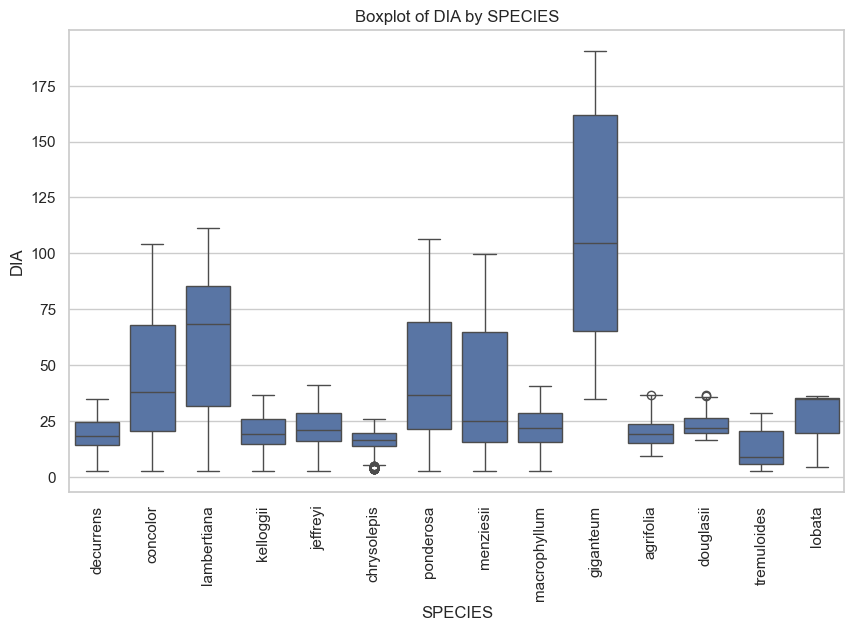

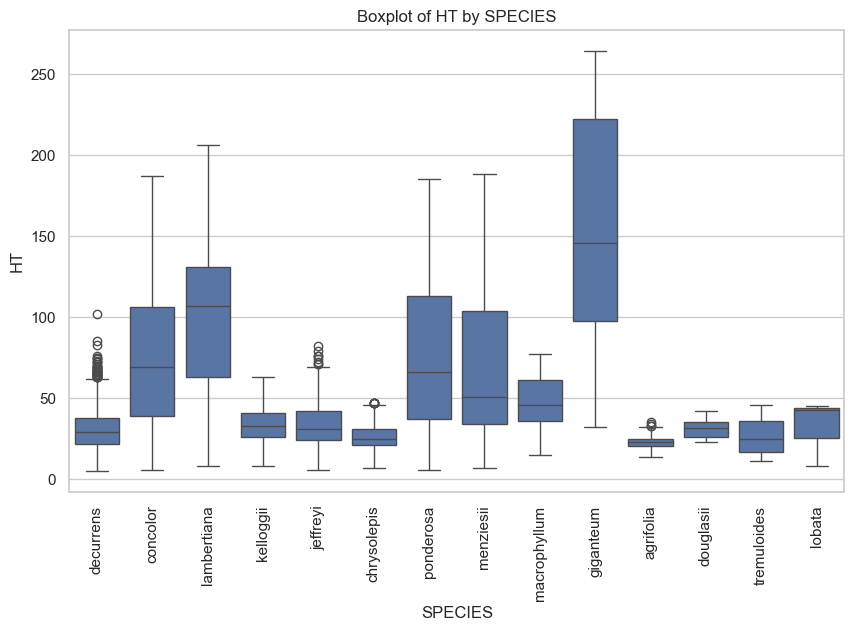

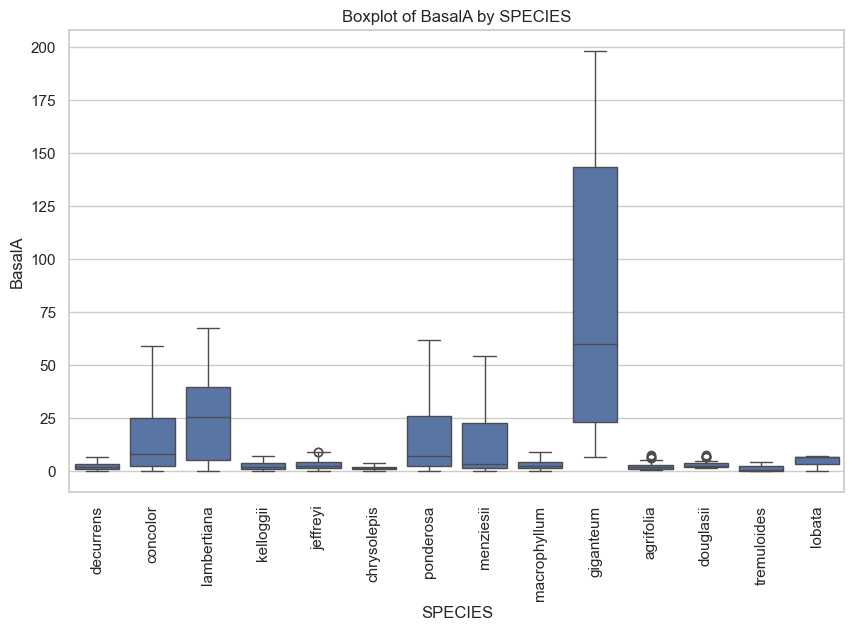

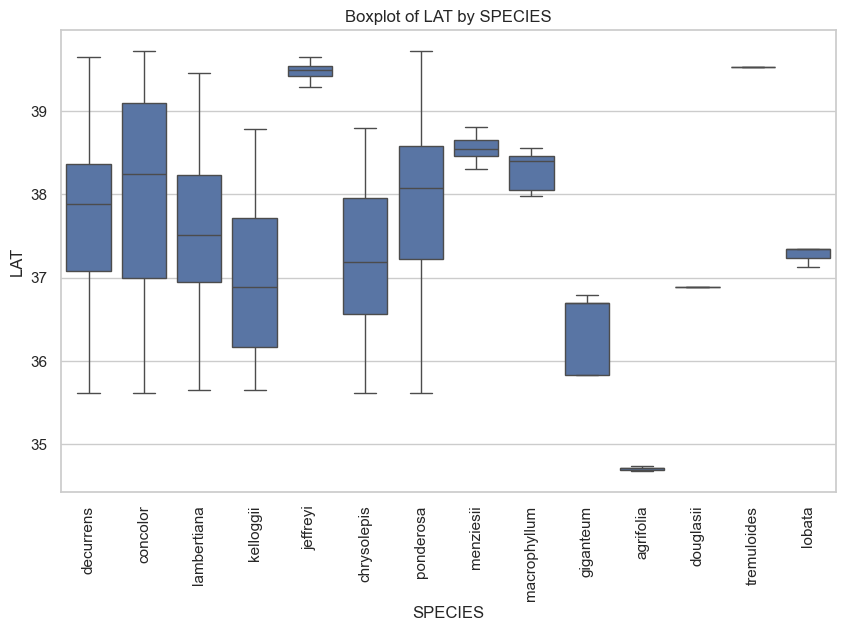

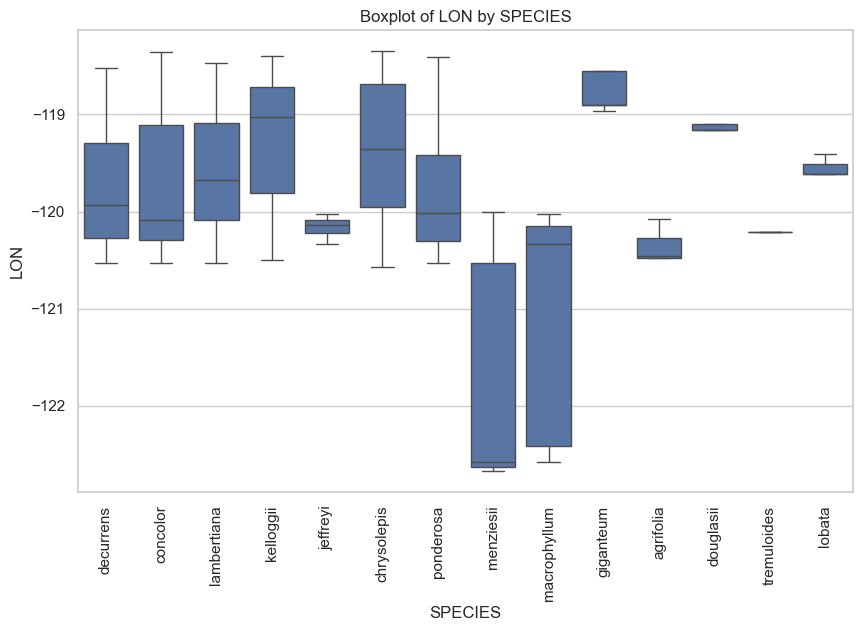

In [1437]:
# make box plots to see outliers 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='DIA', data=df_fia_species)
plt.xticks(rotation=90)
plt.title('Boxplot of DIA by SPECIES')
plt.show()
plt.figure(figsize=(10, 6))

sns.boxplot(x='SPECIES', y='HT', data=df_fia_species)
plt.xticks(rotation=90)
plt.title('Boxplot of HT by SPECIES')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='BasalA', data=df_fia_species)
plt.xticks(rotation=90)
plt.title('Boxplot of BasalA by SPECIES')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='LAT', data=df_fia_species)
plt.xticks(rotation=90)
plt.title('Boxplot of LAT by SPECIES')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='SPECIES', y='LON', data=df_fia_species)
plt.xticks(rotation=90)
plt.title('Boxplot of LON by SPECIES')
plt.show()

In [1438]:
# Selecting important features
include_vars = ['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT', 'SPECIES', 'GENUS']

df = df_fia_species[include_vars].dropna().copy()

# Create the encoder
ohe = OneHotEncoder(sparse_output=False)

# Fit and transform the PFT column
pft_encoded = ohe.fit_transform(df[["PFT"]])

# Convert to DataFrame with appropriate column names
pft_encoded_df = pd.DataFrame(
    pft_encoded,
    columns=[f"PFT_{cat}" for cat in ohe.categories_[0]],
    index=df.index
)

# Drop the original PFT column and join the encoded columns
df = df.drop(columns=["PFT"])
df = pd.concat([df, pft_encoded_df], axis=1)

#one-hot encode the GENUS column
genus_encoded = ohe.fit_transform(df[["GENUS"]])
genus_encoded_df = pd.DataFrame(
    genus_encoded,
    columns=[f"GENUS_{cat}" for cat in ohe.categories_[0]],
    index=df.index
)
# Drop the original GENUS column and join the encoded columns
df = df.drop(columns=["GENUS"])
df = pd.concat([df, genus_encoded_df], axis=1)


X = df.drop(columns=["SPECIES"])
y = df["SPECIES"]

# Encode target variable
le_species = LabelEncoder()
y_encoded = le_species.fit_transform(y)
num_classes = len(le_species.classes_)


# Stratified train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.30, stratify=y_encoded
)

from sklearn.compose import ColumnTransformer

# Identify numerical and categorical columns again
numerical_cols = ['DIA', 'HT', 'LAT', 'LON']
categorical_cols = [col for col in X.columns if col not in numerical_cols]

# Create column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        # ("cat", OneHotEncoder(sparse_output=False), categorical_cols)
    ]
)

# Fit and transform training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


# Concatenate scaled numerical and raw categorical columns
X_train_processed = np.hstack((X_train_scaled, X_train[categorical_cols].values))
X_test_processed = np.hstack((X_test_scaled, X_test[categorical_cols].values))

In [1439]:
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_encoded)

# Check all shapes
print(f"X: {X.shape}, y: {len(y_encoded)}, sample_weights: {len(sample_weights)}")

X: (15225, 20), y: 15225, sample_weights: 15225


In [1440]:
# Apply the column transformer to the dataset
X_new = np.hstack((preprocessor.fit_transform(X), X[categorical_cols].values))

In [1441]:
# Training the base learner - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Best tuned model configuration
best_rf_model = RandomForestClassifier(
    class_weight={
        0: 3.6483766233766235,
        1: 0.6677561207511291,
        2: 0.25883355599576174,
        3: 0.4001210653753027,
        4: 9.909171075837742,
        5: 33.44345238095238,
        6: 1.182095518619819,
        7: 1.141739483844747,
        8: 1.182095518619819,
        9: 133.77380952380952,
        10: 17.448757763975156,
        11: 1.4462033462033461,
        12: 0.41869736940159474,
        13: 44.59126984126984
    },
    max_depth=100,
    max_features='log2',
    n_estimators=200,
    random_state=42
)

# Evaluation function
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

# Run final training + evaluation
train_and_evaluate(best_rf_model, "Best Random Forest (Final)")

#test the random forest model on the test set
predictions = best_rf_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
report = classification_report(y_test_encoded, predictions)
print(report)

Best Random Forest (Final) - Accuracy: 0.9729, Training Time: 1.37 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       495
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       872
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         9
           6       0.94      0.96      0.95       191
           7       1.00      1.00      1.00       318
           8       0.87      0.75      0.80       288
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       186
          12       0.91      0.95      0.93       821
          13       1.00      1.00      1.00         6

    accuracy                           0.97      4568
   macro avg       0.91      0.90      0.91      4568
weigh

/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/an

In [1442]:
# Training the base learner - Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Best tuned Extra Trees model config
best_et_model = ExtraTreesClassifier(
    n_estimators=600,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    max_depth=None,
    criterion='gini',
    bootstrap=False,
    random_state=42
)

# Evaluation function
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

# Run final training + evaluation
train_and_evaluate(best_et_model, "Best Extra Trees (Final)")

predictions = best_et_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
report = classification_report(y_test_encoded, predictions)
print(report)

Best Extra Trees (Final) - Accuracy: 0.9746, Training Time: 3.96 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       495
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       872
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         9
           6       0.96      0.97      0.96       191
           7       1.00      1.00      1.00       318
           8       0.84      0.80      0.82       288
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       186
          12       0.92      0.94      0.93       821
          13       1.00      1.00      1.00         6

    accuracy                           0.97      4568
   macro avg       0.98      0.98      0.98      4568
weighte

In [1443]:
# Training the base learner - Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Best tuned Decision Tree model config
best_dt_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=50,
    min_samples_leaf=4,
    min_samples_split=15,
    random_state=42
)

# Evaluation function (assumed already defined)
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

# Train + evaluate the final Decision Tree model
train_and_evaluate(best_dt_model, "Best Decision Tree (Final)")

predictions = best_dt_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
report = classification_report(y_test_encoded, predictions)
print(report)

Best Decision Tree (Final) - Accuracy: 0.9637, Training Time: 0.03 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       495
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       872
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         9
           6       0.97      0.95      0.96       191
           7       1.00      1.00      1.00       318
           8       0.73      0.76      0.74       288
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       186
          12       0.90      0.90      0.90       821
          13       1.00      1.00      1.00         6

    accuracy                           0.96      4568
   macro avg       0.90      0.90      0.90      4568
weigh

/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/an

In [1444]:
# Training the meta-learner - Stacking with XGBoost
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Reuse base models
base_models = [
    ('rf', best_rf_model),
    ('et', best_et_model),
    ('dt', best_dt_model)
]

# Meta-learner with best-found XGB config
best_xgb_meta = XGBClassifier(
    n_estimators=50,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=2,
    subsample=1.0,               
    colsample_bytree=0.9,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Final stacking model
best_stack_xgb_model = StackingClassifier(
    estimators=base_models,
    final_estimator=best_xgb_meta,
    cv=5,
    n_jobs=-1
)

# Evaluation function
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train_processed, y_train_encoded)
    predictions = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test_encoded, predictions)
    report = classification_report(y_test_encoded, predictions)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} - Accuracy: {accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    print(report)
    print("-" * 50)

# Train + evaluate final stacking model
train_and_evaluate(best_stack_xgb_model, "Final Stacking with XGBoost")


/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:53:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Stacking with XGBoost - Accuracy: 0.9744, Training Time: 13.24 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       495
           2       1.00      1.00      1.00      1329
           3       1.00      1.00      1.00       872
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         9
           6       0.96      0.98      0.97       191
           7       1.00      1.00      1.00       318
           8       0.84      0.79      0.81       288
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00       186
          12       0.92      0.94      0.93       821
          13       1.00      1.00      1.00         6

    accuracy                           0.97      4568
   macro avg       0.91      0.91      0.91      4568
wei

/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1445]:
# Fitting the data to final stacked model
best_stack_xgb_model.fit(X_new,y_encoded, sample_weight=sample_weights)

/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/sdsc/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight={0: 3.6483766233766235,
                                                                     1: 0.6677561207511291,
                                                                     2: 0.25883355599576174,
                                                                     3: 0.4001210653753027,
                                                                     4: 9.909171075837742,
                                                                     5: 33.44345238095238,
                                                                     6: 1.182095518619819,
                                                                     7: 1.141739483844747,
                                                                     8: 1.182095518619819,
                                                                     9: 133.77380952380952,
                                                                     10: 17.448757763975156,
                                                                     11: 1.4462033462033461,
                                                                     12: 0.4186973694015947...
                                                 feature_weights=None, gamma=0,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.01,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=2,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                   n_jobs=-1)

In [1446]:
# Evaluation
predictions = best_stack_xgb_model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, predictions)
predictions = le_species.inverse_transform(predictions)
y_test_labels = le_species.inverse_transform(y_test_encoded)  # Transform y_test_encoded to original labels
report = classification_report(y_test_labels, predictions)  # Use transformed labels
print(report)

              precision    recall  f1-score   support

   agrifolia       1.00      1.00      1.00        22
 chrysolepis       1.00      1.00      1.00       495
    concolor       1.00      1.00      1.00      1329
   decurrens       1.00      1.00      1.00       872
   douglasii       1.00      1.00      1.00        10
   giganteum       1.00      1.00      1.00         9
    jeffreyi       0.93      1.00      0.96       191
   kelloggii       1.00      1.00      1.00       318
 lambertiana       1.00      1.00      1.00       288
      lobata       1.00      1.00      1.00         1
macrophyllum       1.00      1.00      1.00        20
   menziesii       1.00      1.00      1.00       186
   ponderosa       1.00      0.98      0.99       821
 tremuloides       1.00      1.00      1.00         6

    accuracy                           1.00      4568
   macro avg       1.00      1.00      1.00      4568
weighted avg       1.00      1.00      1.00      4568



In [1447]:
df_field['SPECIES_NEW'].value_counts(normalize=True) * 100

SPECIES_NEW
decurrens       22.263624
concolor        20.912902
agrifolia       14.299022
menziesii        8.476945
contorta         8.290638
jeffreyi         5.589194
kelloggii        3.493246
densiflorus      2.980904
magnifica        2.887750
ponderosa        2.748020
douglasii        2.421984
lambertiana      1.630182
tremuloides      1.071262
chrysolepis      0.931532
sp.              0.745226
nuttalii         0.558919
lobata           0.279460
giganteum        0.232883
scouleriana      0.093153
glabrum          0.046577
macrophyllum     0.046577
Name: proportion, dtype: float64

### Working with TLS data

In [1448]:
# One-hot encode the PFT column
genus_encoded = pd.get_dummies(TLS_species['predicted_genus'], prefix='GENUS')

# Concatenate the one-hot encoded columns with the original DataFrame
TLS_species = pd.concat([TLS_species, genus_encoded], axis=1)

# Drop the original PFT column
TLS_species.drop(columns=['predicted_genus'], inplace=True)

# Display the updated DataFrame
TLS_species.head()

,DIA,HT,BasalA,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,GENUS_Abies,GENUS_Acer,GENUS_Calocedrus,GENUS_Pinus,GENUS_Pseudotsuga,GENUS_Quercus,GENUS_Sequoiadendron
0,20.987379,12.560,2.402324,0.000019,-121.488648,False,False,False,False,M261Ep,False,True,False,False,False,False,False,False,True,False
1,13.105771,8.742,0.936786,0.000010,-121.488722,False,False,False,False,M261Ep,False,True,False,False,False,False,False,False,True,False
2,59.840890,13.469,19.530404,0.000009,-121.488725,False,False,False,False,M261Ep,False,True,False,False,False,False,False,False,True,False
3,21.040854,18.144,2.414582,0.000079,-121.488726,False,False,False,False,M261Ep,False,False,True,False,False,False,True,False,False,False
4,16.390056,13.790,1.465130,0.000002,-121.488731,False,False,False,False,M261Ep,False,True,False,False,False,False,False,False,True,False


In [1449]:
# Adding these two columns as they are not predicted by the model and settinhg them to false to match the training dimensions
# This still means that the genus for current model is not Arbutus, Lithocarpus, Populus
TLS_species[['GENUS_Arbutus', 'GENUS_Populus']] = False, False

In [1450]:
# Selecting the features for model prediction
TLS_species_features = TLS_species[['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am','ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer', 'GENUS_Abies',
       'GENUS_Acer', 'GENUS_Calocedrus', 'GENUS_Pinus', 'GENUS_Pseudotsuga',
       'GENUS_Quercus', 'GENUS_Sequoiadendron', 'GENUS_Arbutus',
       'GENUS_Populus']]
len(TLS_species_features)

1286

In [1451]:
categorical_cols = [col for col in TLS_species_features.columns if col not in numerical_cols]
TLS_species_features_array = np.hstack((preprocessor.fit_transform(TLS_species), TLS_species[categorical_cols].values))
#predictions
pred =  best_stack_xgb_model.predict(TLS_species_features_array)
predicted_species = le_species.inverse_transform(pred)
TLS_species['predicted_species'] = predicted_species.copy()
TLS_species['predicted_species'].value_counts()


predicted_species
menziesii       361
decurrens       323
concolor        248
ponderosa       212
lambertiana     109
macrophyllum     17
tremuloides      10
jeffreyi          6
Name: count, dtype: int64

In [1454]:
print("Training data distribution:")
print(df_fia_species['SPECIES'].value_counts(normalize=True) * 100)

Training data distribution:
SPECIES
concolor        29.096880
decurrens       19.087028
ponderosa       17.963875
chrysolepis     10.844007
kelloggii        6.962233
lambertiana      6.292282
jeffreyi         4.190476
menziesii        4.078818
agrifolia        0.486043
macrophyllum     0.433498
douglasii        0.223317
giganteum        0.197044
tremuloides      0.124795
lobata           0.019704
Name: proportion, dtype: float64


In [1455]:
print("-" * 30)

# find percentage of each predicted genus
predicted_species_counts = TLS_species['predicted_species'].value_counts(normalize=True) * 100
# Display the percentage of each predicted genus
print("Percentage of each predicted species:")
print(predicted_species_counts)
print("-" * 30)

print("Field data distribution")
print(df_field["SPECIES_NEW"].value_counts(normalize=True) * 100)


------------------------------
Percentage of each predicted species:
predicted_species
menziesii       28.071540
decurrens       25.116641
concolor        19.284603
ponderosa       16.485226
lambertiana      8.475894
macrophyllum     1.321928
tremuloides      0.777605
jeffreyi         0.466563
Name: proportion, dtype: float64
------------------------------
Field data distribution
SPECIES_NEW
decurrens       22.263624
concolor        20.912902
agrifolia       14.299022
menziesii        8.476945
contorta         8.290638
jeffreyi         5.589194
kelloggii        3.493246
densiflorus      2.980904
magnifica        2.887750
ponderosa        2.748020
douglasii        2.421984
lambertiana      1.630182
tremuloides      1.071262
chrysolepis      0.931532
sp.              0.745226
nuttalii         0.558919
lobata           0.279460
giganteum        0.232883
scouleriana      0.093153
glabrum          0.046577
macrophyllum     0.046577
Name: proportion, dtype: float64


Here, we have decurrens predicted as 25% (Predicted) to 22% (Field data) and concolor coming in close at 19% (Predicted) to 20% (Field)